## Setup and Data Import

In [1]:
import colormaps as cmaps
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from sqlmodel import Session, select

from rs_graph.db import models as db_models
from rs_graph.db.utils import get_engine

plt.style.use("opinionated_rc")
sns.set_palette(
    cmaps.bold[2:]._colors.tolist(),
)

In [2]:
# get a dataset of linked repos and papers
linked_doc_repos: list[dict[str, str | float | int | None]] = []
repo_contributors: list[dict[str, str | float | int | None]] = []
doc_contributors: list[dict[str, str | float | int | None]] = []
matched_contributors: list[dict[str, str | float | int | None]] = []
doc_fields: list[dict[str, str | float | int | None]] = []
engine = get_engine(prod=True)
with Session(engine) as session:
    # Get linked docs repos
    doc_repo_statement = (
        select(
            db_models.Document,
            db_models.Repository,
        )
        .join(
            db_models.DocumentRepositoryLink,
            db_models.DocumentRepositoryLink.document_id == db_models.Document.id,
        )
        .join(
            db_models.Repository,
            db_models.DocumentRepositoryLink.repository_id == db_models.Repository.id,
        )
        .join(
            db_models.DatasetSource,
            db_models.DocumentRepositoryLink.dataset_source_id
            == db_models.DatasetSource.id,
        )
        .where(db_models.DatasetSource.name == "plos")
    )

    # For each one, we need to get count of contributors for document and repository
    for doc, repo in session.exec(doc_repo_statement):
        linked_doc_repos.append(
            {
                "document_id": doc.id,
                "document_publication_date": doc.publication_date,
                "document_cited_by_count": doc.cited_by_count,
                "repository_id": repo.id,
                "repository_forks_count": repo.forks_count,
                "repository_stargazers_count": repo.stargazers_count,
                "repository_watchers_count": repo.watchers_count,
                "repository_open_issues_count": repo.open_issues_count,
                "repository_size_kb": repo.size_kb,
                "repository_creation_datetime": repo.creation_datetime,
                "repository_last_pushed_datetime": repo.last_pushed_datetime,
            }
        )

    # Get all repo contributors
    repo_contributors_statement = (
        select(
            db_models.Repository,
            db_models.DeveloperAccount,
        )
        .join(
            db_models.RepositoryContributor,
            db_models.RepositoryContributor.repository_id == db_models.Repository.id,
        )
        .join(
            db_models.DeveloperAccount,
            db_models.RepositoryContributor.developer_account_id
            == db_models.DeveloperAccount.id,
        )
    )

    for repo, dev in session.exec(repo_contributors_statement):
        repo_contributors.append(
            {
                "repository_id": repo.id,
                "developer_account_id": dev.id,
                "developer_account_username": dev.username,
                "developer_name": dev.name,
                "developer_email": dev.email,
            }
        )

    # Get all doc contributors
    doc_contributors_statement = (
        select(
            db_models.Document,
            db_models.DocumentContributor,
            db_models.Researcher,
        )
        .join(
            db_models.DocumentContributor,
            db_models.DocumentContributor.document_id == db_models.Document.id,
        )
        .join(
            db_models.Researcher,
            db_models.DocumentContributor.researcher_id == db_models.Researcher.id,
        )
    )

    for doc, doc_contributor, researcher in session.exec(doc_contributors_statement):
        doc_contributors.append(
            {
                "document_id": doc.id,
                "researcher_id": researcher.id,
                "researcher_name": researcher.name,
                "researcher_works_count": researcher.works_count,
                "researcher_cited_by_count": researcher.cited_by_count,
                "researcher_h_index": researcher.h_index,
                "researcher_i10_index": researcher.i10_index,
                "researcher_two_year_mean_citedness": researcher.two_year_mean_citedness,
                "document_researcher_position": doc_contributor.position,
                "document_researcher_is_corresponding": doc_contributor.is_corresponding,
            }
        )

    # Get all matched contributors
    matched_contributors_statement = (
        select(
            db_models.DeveloperAccount,
            db_models.Researcher,
        )
        .join(
            db_models.ResearcherDeveloperAccountLink,
            db_models.ResearcherDeveloperAccountLink.developer_account_id
            == db_models.DeveloperAccount.id,
        )
        .join(
            db_models.Researcher,
            db_models.ResearcherDeveloperAccountLink.researcher_id
            == db_models.Researcher.id,
        )
    )

    for dev, researcher in session.exec(matched_contributors_statement):
        matched_contributors.append(
            {
                "developer_account_id": dev.id,
                "researcher_id": researcher.id,
            }
        )

    # Get all doc topics
    doc_topics_statement = (
        select(
            db_models.Document,
            db_models.Topic,
        )
        .join(
            db_models.DocumentTopic,
            db_models.DocumentTopic.document_id == db_models.Document.id,
        )
        .join(
            db_models.Topic,
            db_models.DocumentTopic.topic_id == db_models.Topic.id,
        )
    )

    for doc, topic in session.exec(doc_topics_statement):
        doc_fields.append(
            {
                "document_id": doc.id,
                "topic_id": topic.id,
                "topic_field_name": topic.domain_name,
            }
        )

linked_doc_repos_df = pd.DataFrame(linked_doc_repos)
repo_contributors_df = pd.DataFrame(repo_contributors)
doc_contributors_df = pd.DataFrame(doc_contributors)
matched_contributors_df = pd.DataFrame(matched_contributors)
doc_fields_df = pd.DataFrame(doc_fields)

# Drop any papers that were published before 2015 and after 2023
linked_doc_repos_df["document_publication_year"] = pd.to_datetime(
    linked_doc_repos_df["document_publication_date"]
).dt.year
linked_doc_repos_df = linked_doc_repos_df[
    (linked_doc_repos_df["document_publication_year"] >= 2016)
    & (linked_doc_repos_df["document_publication_year"] < 2024)
]

# Drop any linked_doc_repos that are used multiple times
linked_doc_repos_df = linked_doc_repos_df.drop_duplicates(
    subset=["document_id"],
    keep=False,
)

## Dataset Description

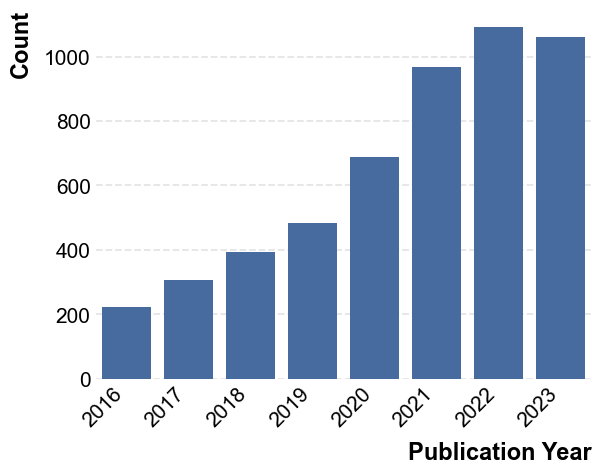

In [3]:
sns.barplot(
    linked_doc_repos_df.document_publication_year.value_counts()
    .to_frame()
    .reset_index()
    .rename(
        columns={"document_publication_year": "Publication Year", "count": "Count"}
    ),
    x="Publication Year",
    y="Count",
)
_ = plt.xticks(rotation=45, ha="right")

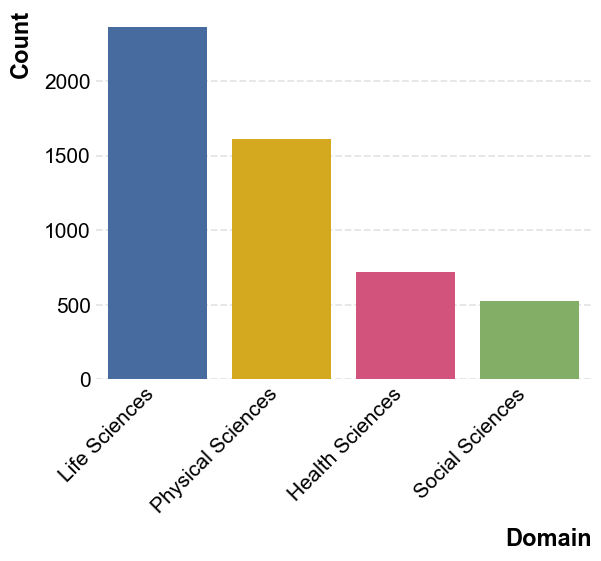

In [4]:
plos_doc_fields_df = doc_fields_df.loc[
    doc_fields_df["document_id"].isin(linked_doc_repos_df["document_id"])
].drop_duplicates(subset=["document_id"])

sns.barplot(
    plos_doc_fields_df["topic_field_name"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(
        columns={
            "topic_field_name": "Domain",
            "count": "Count",
        }
    ),
    x="Domain",
    y="Count",
    hue="Domain",
)
_ = plt.xticks(rotation=45, ha="right")

## Author-Developer Collaboration Patterns

### Authorship and Contributorship

N linked doc-repo pairs: 5042


,mean,std,min,25%,50%,75%,max
Article Authors,5.520230e+00,3.965044,1.000000,3.000000,4.000000,7.000000,44.000000
Repository Contributors,1.896470e+00,3.313542,1.000000,1.000000,1.000000,2.000000,30.000000
Matched Author-Contributors,1.064855e+00,0.910364,0.000000,1.000000,1.000000,1.000000,17.000000
Non-Credited Repository Contributors,8.316144e-01,3.084991,0.000000,0.000000,0.000000,1.000000,30.000000
Total Team Size,6.351845e+00,5.062118,1.000000,3.000000,5.000000,8.000000,46.000000
Document Citations,1.969595e+01,58.090844,0.000000,2.000000,7.000000,19.000000,1634.000000
Subj-Year Norm Document Citations,1.409248e-18,0.996920,-1.239193,-0.489325,-0.278891,0.104897,14.442893


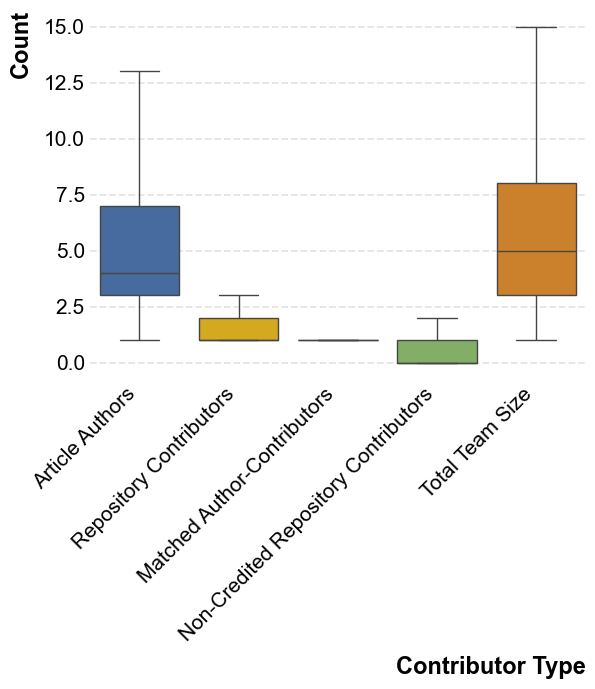

In [5]:
# Create a dataframe of:
# "document_id",
# "Domain",
# "Year",
# "Number of Code-Contributors",
# "Number of Non-Code-Contributors",
# "Number of Matched Contributors",
# "Number of Non-Credited Contributors",
# "Number of Total Contributors",
per_paper_counts = []
for _, row in linked_doc_repos_df.iterrows():
    # Get Domain
    domain = doc_fields_df.loc[doc_fields_df["document_id"] == row["document_id"]].iloc[
        0
    ]["topic_field_name"]

    # Get matching doc contributors
    doc_contributors = doc_contributors_df.loc[
        doc_contributors_df["document_id"] == row["document_id"]
    ]

    # Get matching repo contributors
    repo_contributors = repo_contributors_df.loc[
        repo_contributors_df["repository_id"] == row["repository_id"]
    ]

    # Get matching matched contributors
    matched_contributors = matched_contributors_df.loc[
        (
            matched_contributors_df["researcher_id"].isin(
                doc_contributors["researcher_id"]
            )
        )
        & (
            matched_contributors_df["developer_account_id"].isin(
                repo_contributors["developer_account_id"]
            )
        )
    ]

    # Get non-credited contributors
    non_credited_contributors = len(repo_contributors) - len(matched_contributors)

    # Get total contributors
    total_contributors = len(doc_contributors) + non_credited_contributors

    if any(
        [
            len(doc_contributors) == 0,
            len(repo_contributors) == 0,
            non_credited_contributors < 0,
        ]
    ):
        continue

    per_paper_counts.append(
        {
            "document_id": row["document_id"],
            "Domain": domain,
            "Year": row["document_publication_year"],
            "Article Authors": len(doc_contributors),
            "Repository Contributors": len(repo_contributors),
            "Matched Author-Contributors": len(matched_contributors),
            "Non-Credited Repository Contributors": non_credited_contributors,
            "Total Team Size": total_contributors,
            "Document Citations": row["document_cited_by_count"],
        }
    )

# Convert to dataframe
per_paper_counts_df = pd.DataFrame(per_paper_counts)

# Create a column for mean normalized document citations
# Groupby Domain and Year
per_paper_counts_df["Subj-Year Norm Document Citations"] = per_paper_counts_df.groupby(
    ["Domain", "Year"]
)["Document Citations"].transform(lambda x: (x - x.mean()) / x.std())

# Melt the dataframe to long format
per_paper_counts_long_df = per_paper_counts_df.melt(
    id_vars=[
        "document_id",
        "Domain",
        "Year",
        "Document Citations",
        "Subj-Year Norm Document Citations",
    ],
    value_vars=[
        "Article Authors",
        "Repository Contributors",
        "Matched Author-Contributors",
        "Non-Credited Repository Contributors",
        "Total Team Size",
    ],
    var_name="Contributor Type",
    value_name="Count",
)

# Plot violinplots
sns.boxplot(
    data=per_paper_counts_long_df,
    x="Contributor Type",
    y="Count",
    hue="Contributor Type",
    hue_order=[
        "Article Authors",
        "Repository Contributors",
        "Matched Author-Contributors",
        "Non-Credited Repository Contributors",
        "Total Team Size",
    ],
    showfliers=False,
)
_ = plt.xticks(rotation=45, ha="right")

print(f"N linked doc-repo pairs: {len(per_paper_counts_df)}")
# Remove "count" from describe
per_paper_counts_df.drop(columns=["document_id", "Domain", "Year"]).describe().T.drop(
    columns=["count"]
)

/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_70597/3434065517.py:25: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  .drop(columns=["document_id"])


0              1  \
Domain                                   Health Sciences  Life Sciences   
Year                              count            690.0         2285.0   
                                  mean       2020.876812     2020.52779   
                                  std           1.854868       2.055223   
                                  min             2016.0         2016.0   
...                                                  ...            ...   
Subj-Year Norm Document Citations min          -1.200338      -0.827272   
                                  25%           -0.49421      -0.503189   
                                  50%          -0.321388      -0.268211   
                                  75%           0.128926        0.11459   
                                  max           6.248202      11.751106   

                                                         2                3  
Domain                                   Physical Sciences  Social Sciences  
Year                              count             1563.0            504.0  
                                  mean         2020.694818      2020.769841  
                                  std             2.000549          1.97061  
                                  min               2016.0           2016.0  
...                                                    ...              ...  
Subj-Year Norm Document Citations min            -0.940821        -1.239193  
                                  25%            -0.441749        -0.385198  
                                  50%            -0.282704        -0.276216  
                                  75%             0.094678         0.037487  
                                  max            14.442893         7.629471  

[65 rows x 4 columns]

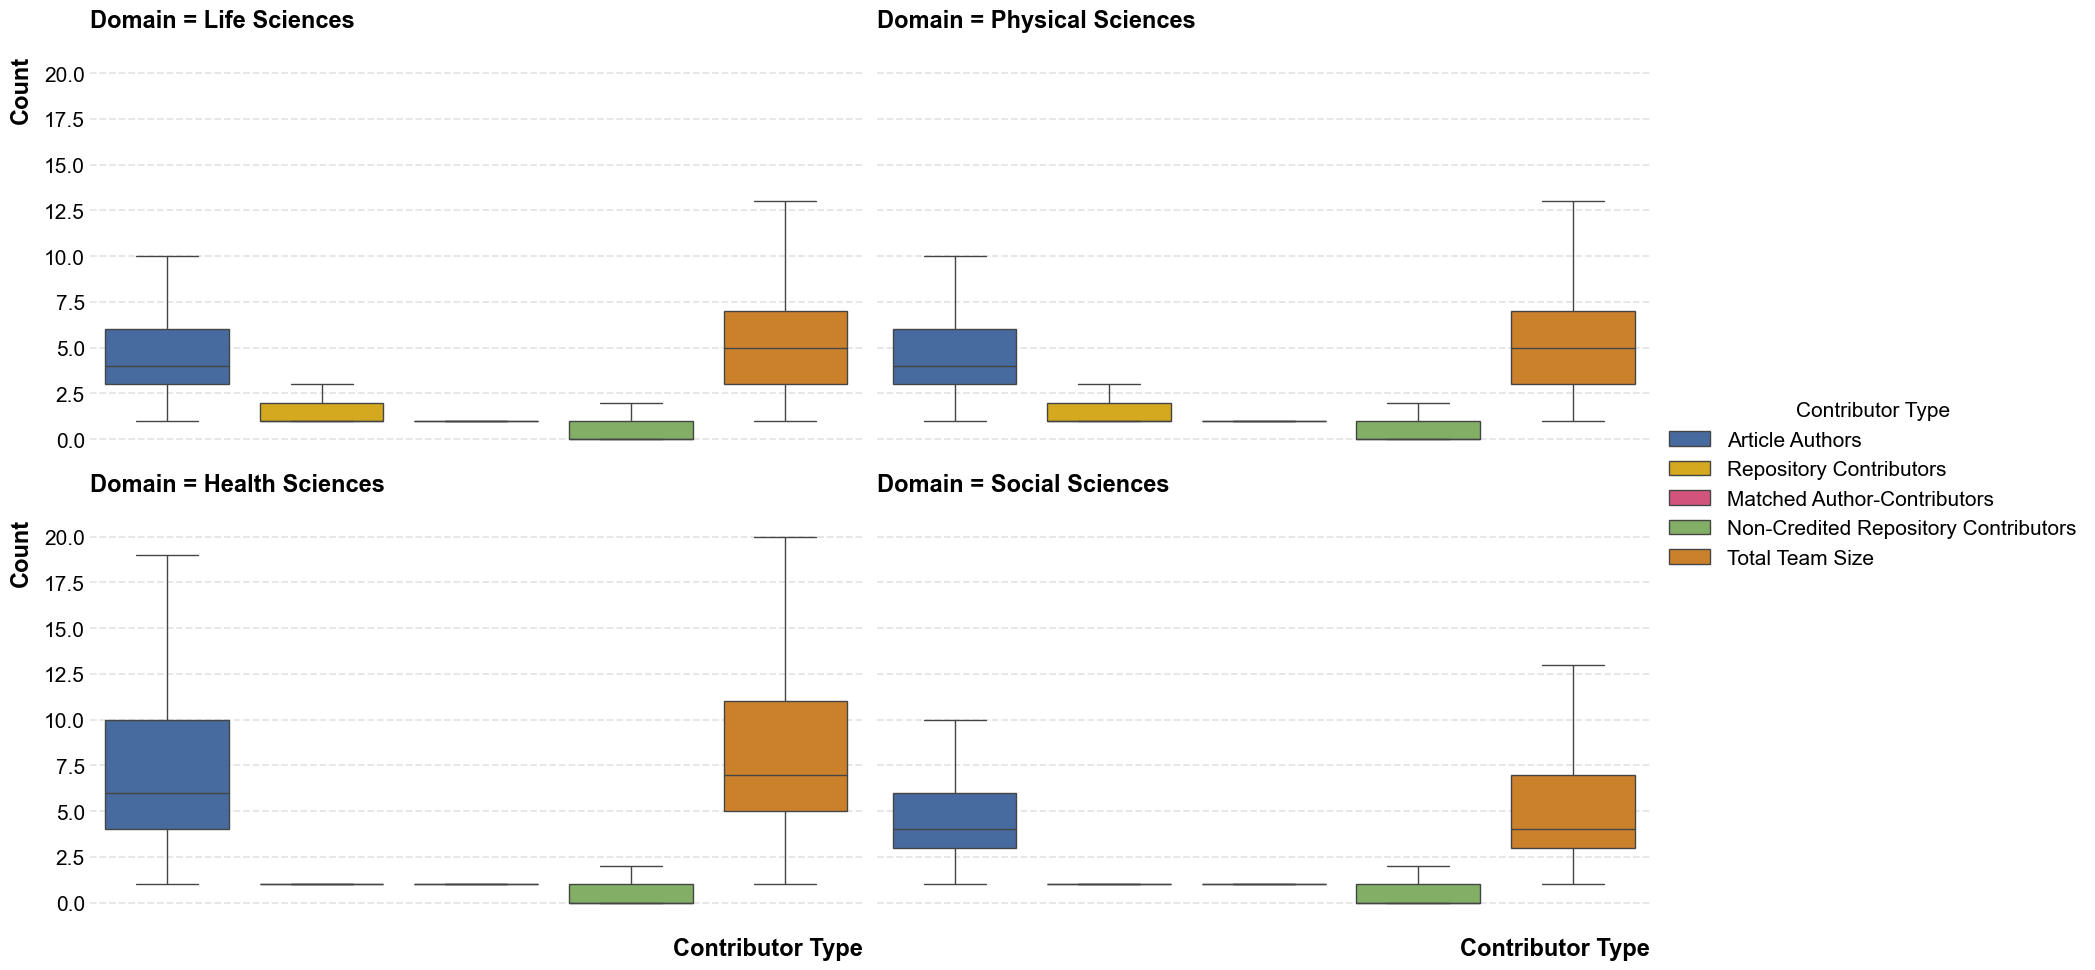

In [6]:
# Do the same thing but for each Domain
g = sns.catplot(
    data=per_paper_counts_long_df,
    x="Contributor Type",
    y="Count",
    hue="Contributor Type",
    col="Domain",
    kind="box",
    showfliers=False,
    col_wrap=2,
    col_order=per_paper_counts_long_df["Domain"].value_counts().index.tolist(),
    legend=True,
    aspect=1.7,
)

# Remove xlabels
for ax in g.axes.flat:
    ax.set_xticklabels([])

# Create dataframe of descriptive statistics
descriptive_stats = (
    per_paper_counts_df.groupby("Domain")
    .describe()
    .reset_index()
    .drop(columns=["document_id"])
    .T
)
descriptive_stats

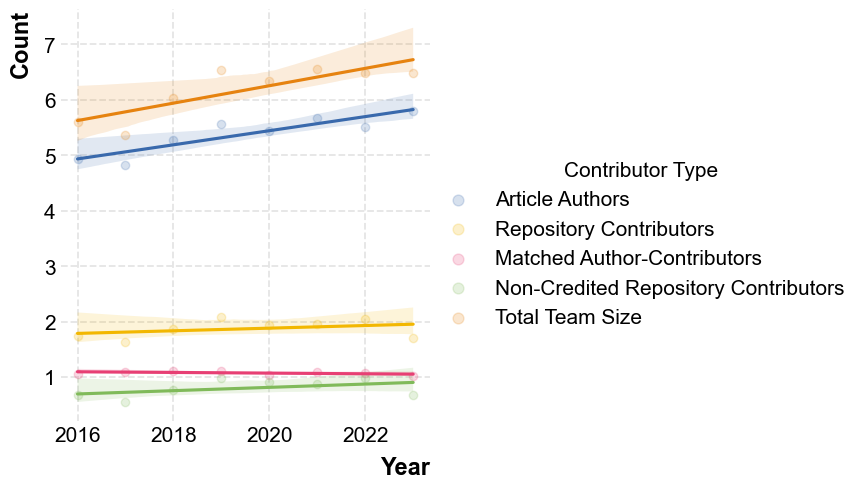

In [7]:
# Drop Discipline and groupby year take mean of metrics
all_domain_year_mean_metrics = (
    per_paper_counts_df.drop(
        columns=[
            "document_id",
            "Domain",
            "Document Citations",
            "Subj-Year Norm Document Citations",
        ],
    )
    .groupby("Year")
    .mean()
    .reset_index()
)
all_domain_year_mean_metrics = all_domain_year_mean_metrics.melt(
    id_vars=["Year"],
    var_name="Contributor Type",
    value_name="Count",
)

# Plot the metrics using seaborn lmplot
sns.lmplot(
    data=all_domain_year_mean_metrics,
    x="Year",
    y="Count",
    hue="Contributor Type",
    scatter_kws={"alpha": 0.2},
    ci=95,
)

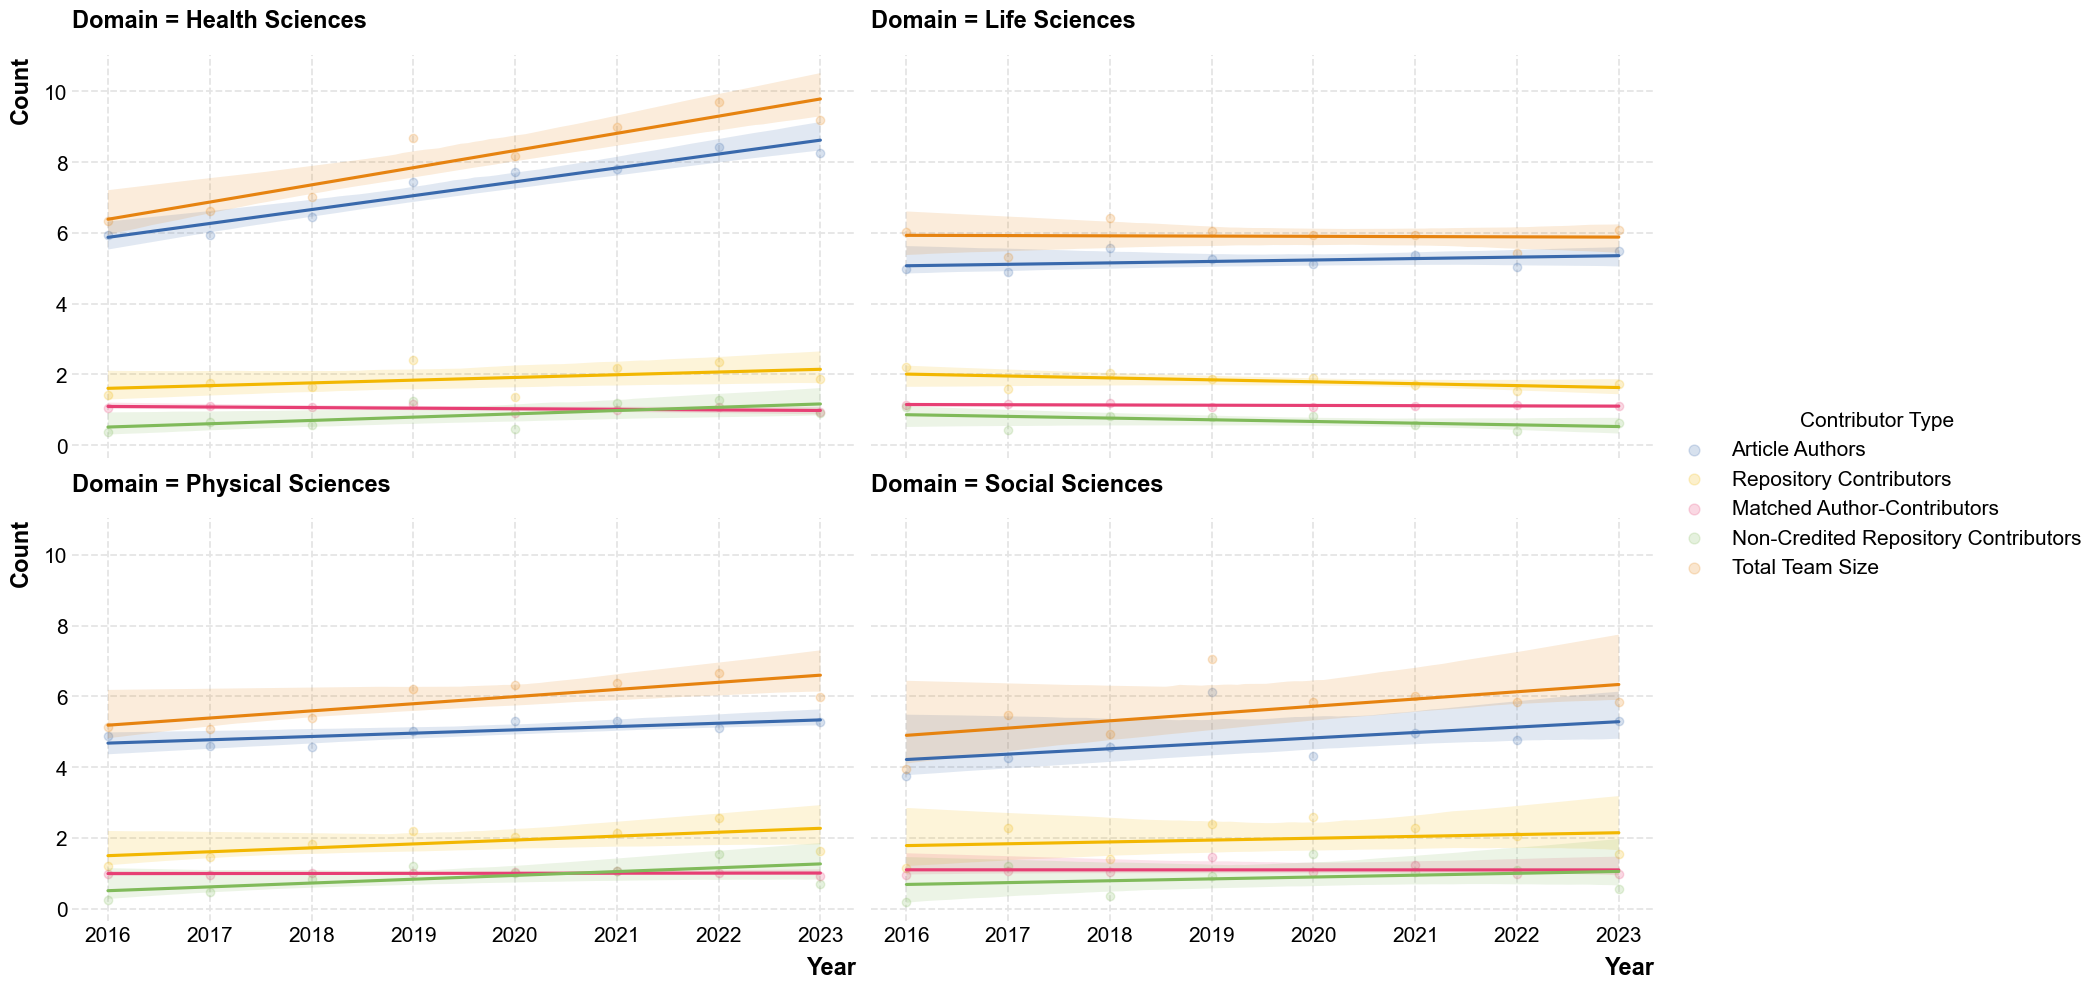

In [8]:
# Same thing but split by Domain
# Drop document_id and groupby year take mean of metrics
domain_year_mean_metrics = (
    per_paper_counts_df.drop(
        columns=[
            "document_id",
            "Document Citations",
            "Subj-Year Norm Document Citations",
        ],
    )
    .groupby(["Domain", "Year"])
    .mean()
    .reset_index()
)

# Melt the dataframe to long format
domain_year_mean_metrics_long = domain_year_mean_metrics.melt(
    id_vars=["Domain", "Year"],
    var_name="Contributor Type",
    value_name="Count",
)

# Plot the metrics using seaborn lmplot
sns.lmplot(
    data=domain_year_mean_metrics_long,
    x="Year",
    y="Count",
    hue="Contributor Type",
    col="Domain",
    col_order=domain_year_mean_metrics["Domain"].value_counts().index.tolist(),
    scatter_kws={"alpha": 0.2},
    ci=95,
    col_wrap=2,
    aspect=1.7,
)

### Separating Authorship and Contributorship

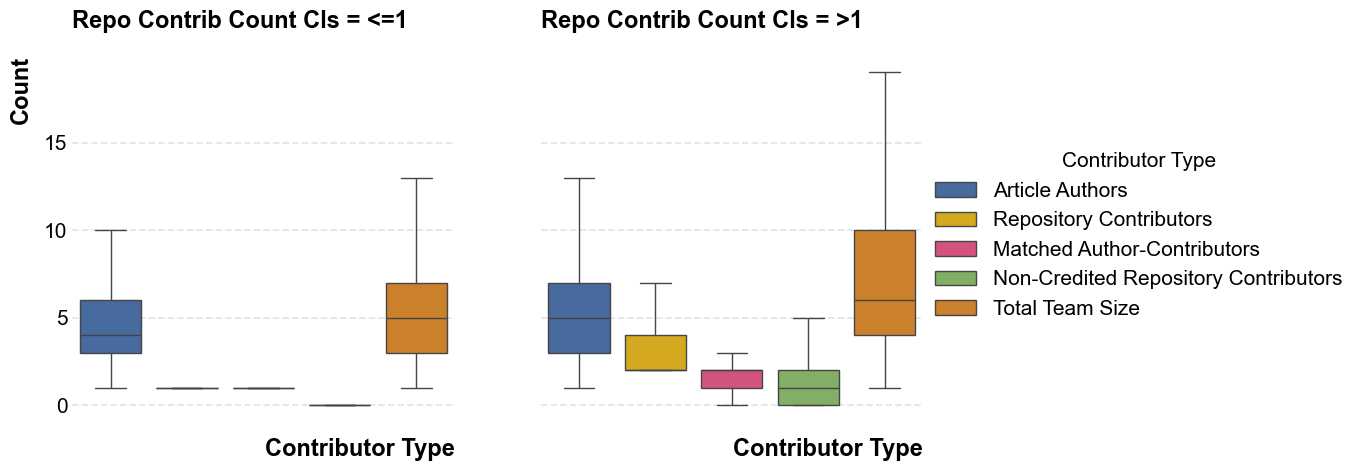

In [9]:
# Make contributor counts categorical
per_paper_counts_df["Repo Contrib Count Cls"] = per_paper_counts_df[
    "Repository Contributors"
].apply(lambda x: "<=1" if x < 2 else ">1")
per_paper_counts_df["Matched Contrib Count Cls"] = per_paper_counts_df[
    "Matched Author-Contributors"
].apply(lambda x: "<=1" if x < 2 else ">1")

# Make long format
per_paper_counts_df_long = per_paper_counts_df.melt(
    id_vars=[
        "document_id",
        "Domain",
        "Year",
        "Document Citations",
        "Subj-Year Norm Document Citations",
        "Repo Contrib Count Cls",
        "Matched Contrib Count Cls",
    ],
    value_vars=[
        "Article Authors",
        "Repository Contributors",
        "Matched Author-Contributors",
        "Non-Credited Repository Contributors",
        "Total Team Size",
    ],
    var_name="Contributor Type",
    value_name="Count",
)

# Plot boxplots
g = sns.catplot(
    data=per_paper_counts_df_long,
    x="Contributor Type",
    y="Count",
    hue="Contributor Type",
    col="Repo Contrib Count Cls",
    col_wrap=2,
    kind="box",
    showfliers=False,
    legend=True,
)

# Remove xlabels
for ax in g.axes.flat:
    ax.set_xticklabels([])

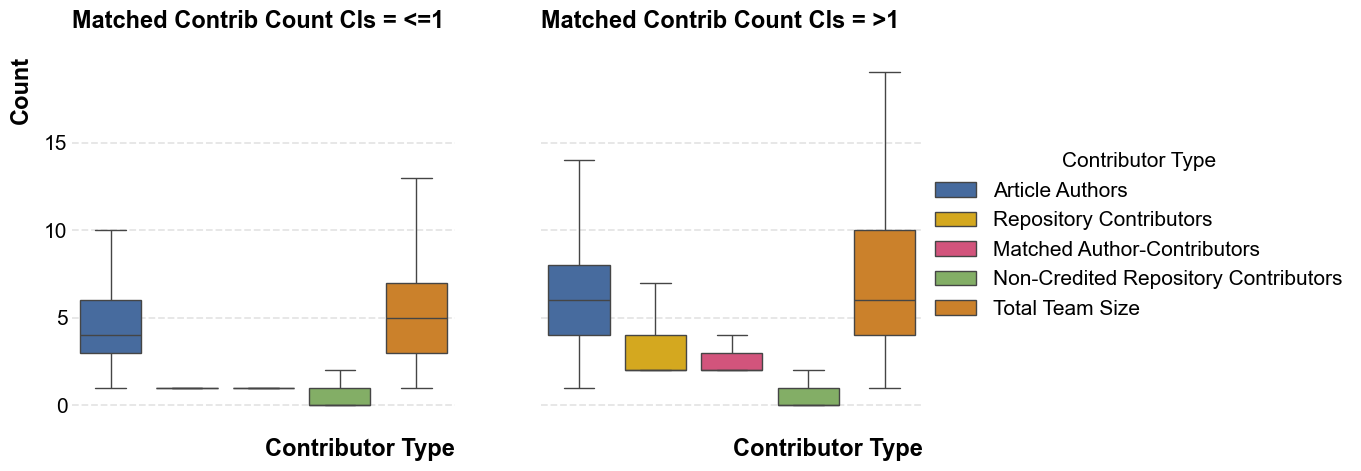

In [10]:
# Plot boxplots
g = sns.catplot(
    data=per_paper_counts_df_long,
    x="Contributor Type",
    y="Count",
    hue="Contributor Type",
    col="Matched Contrib Count Cls",
    col_wrap=2,
    kind="box",
    showfliers=False,
    legend=True,
)

# Remove xlabels
for ax in g.axes.flat:
    ax.set_xticklabels([])

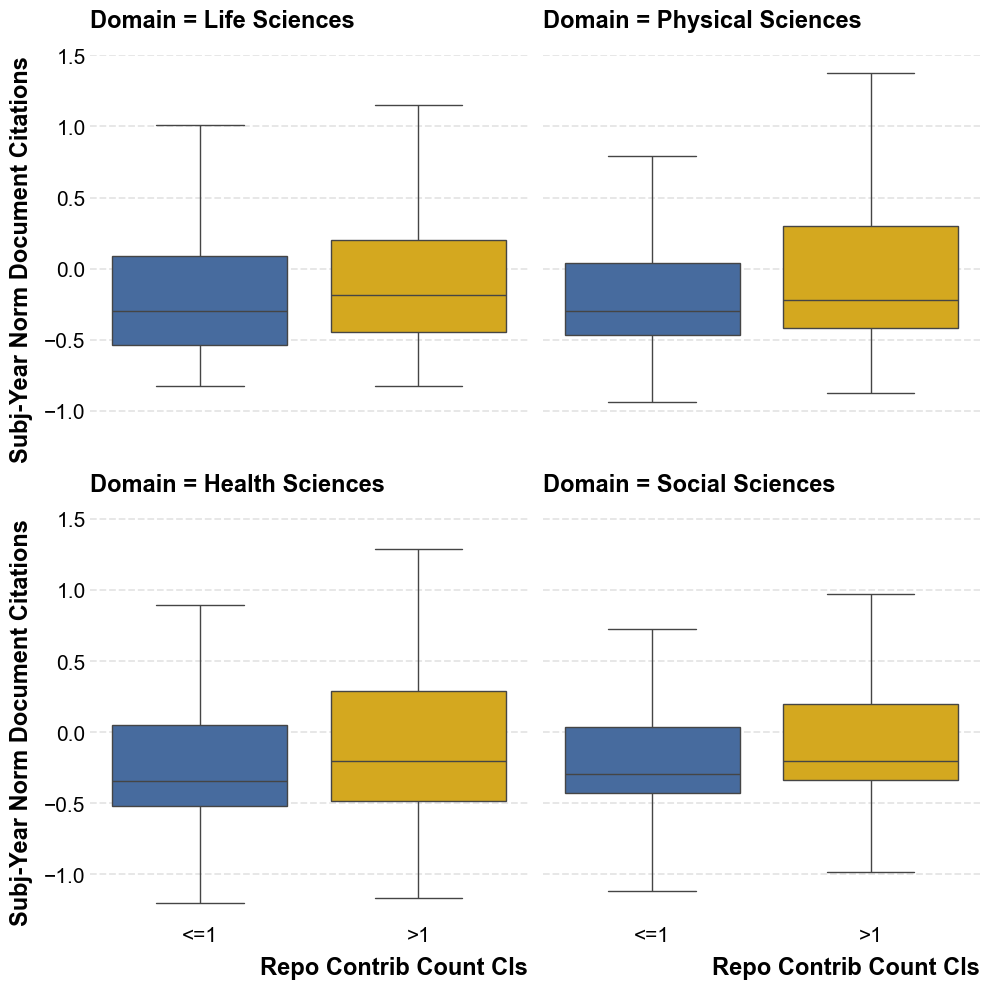

In [11]:
# Create boxplots for each group
sns.catplot(
    data=per_paper_counts_df,
    x="Repo Contrib Count Cls",
    y="Subj-Year Norm Document Citations",
    hue="Repo Contrib Count Cls",
    col="Domain",
    col_order=per_paper_counts_df["Domain"].value_counts().index.tolist(),
    col_wrap=2,
    kind="box",
    showfliers=False,
)

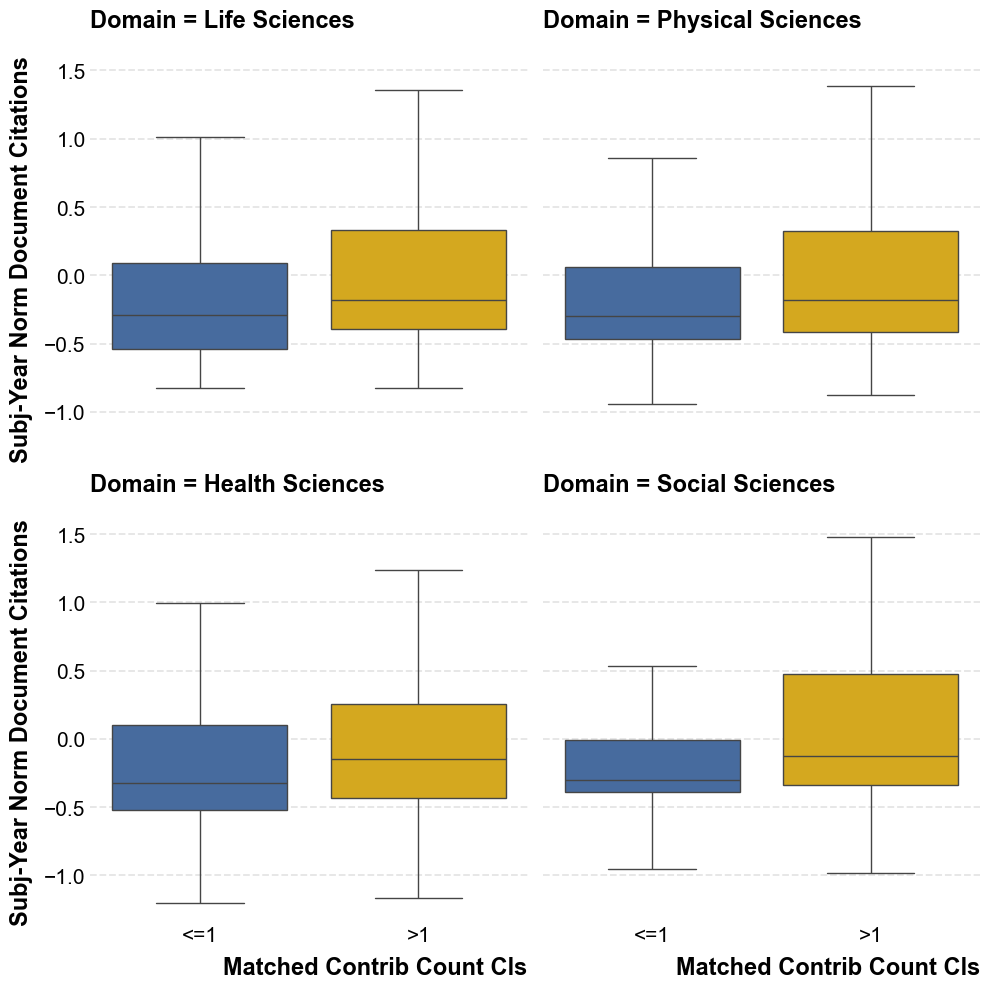

In [12]:
# Create boxplots for each group
sns.catplot(
    data=per_paper_counts_df,
    x="Matched Contrib Count Cls",
    y="Subj-Year Norm Document Citations",
    hue="Matched Contrib Count Cls",
    col="Domain",
    col_order=per_paper_counts_df["Domain"].value_counts().index.tolist(),
    col_wrap=2,
    kind="box",
    showfliers=False,
)

## Who are Developers

### Which Authors Are Developers?

,mean,std,min,25%,50%,75%,max
First Author Developers,0.762720,0.446786,0.0,1.0,1.0,1.0,2.0
Middle Author Developers,0.355675,0.820410,0.0,0.0,0.0,1.0,15.0
Last Author Developers,0.170988,0.376545,0.0,0.0,0.0,0.0,1.0
Corresponding Author Developers,0.850294,0.766688,0.0,0.0,1.0,1.0,14.0


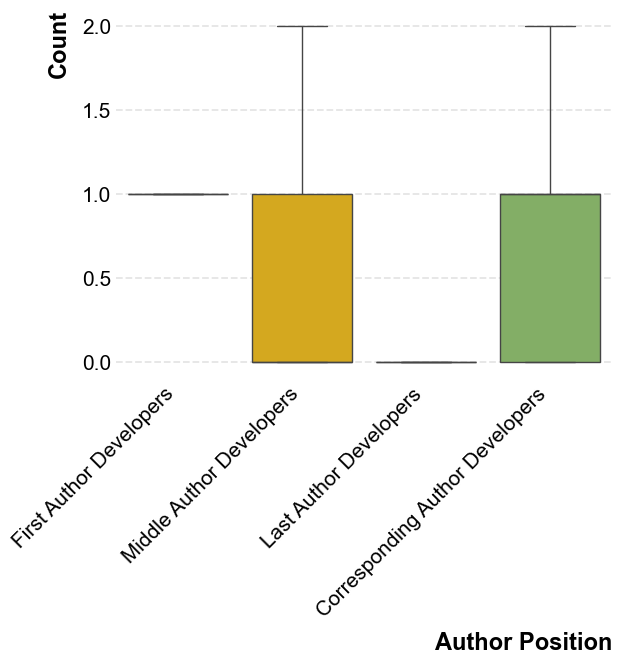

In [13]:
# Create dataframe so we can determine where developers lie in the whole team (by how common they are across all papers)
# Options include: "first author", "middle author", "last author", and "corresponding author"
# Specifically we want a dataframe with:
# "document_id",
# "Domain",
# "Year",
# "First Author Developers",
# "Middle Author Developers",
# "Last Author Developers",
# "Corresponding Author Developers",
# "Total Authors",
# "Document Citations",

per_paper_author_dev_contributors = []
for _, row in linked_doc_repos_df.iterrows():
    # Get domain
    domain = doc_fields_df.loc[doc_fields_df["document_id"] == row["document_id"]].iloc[
        0
    ]["topic_field_name"]

    # Get matching doc contributors
    doc_contributors = doc_contributors_df.loc[
        doc_contributors_df["document_id"] == row["document_id"]
    ]

    # Get matching repo contributors
    repo_contributors = repo_contributors_df.loc[
        repo_contributors_df["repository_id"] == row["repository_id"]
    ]

    # Get matching matched contributors
    matched_contributors = matched_contributors_df.loc[
        (
            matched_contributors_df["researcher_id"].isin(
                doc_contributors["researcher_id"]
            )
        )
        & (
            matched_contributors_df["developer_account_id"].isin(
                repo_contributors["developer_account_id"]
            )
        )
    ]
    if any(
        [
            len(doc_contributors) <= 1,
            len(repo_contributors) == 0,
            len(matched_contributors) == 0,
        ]
    ):
        continue

    # Keep track of counts
    first_author_devs = 0
    middle_author_devs = 0
    last_author_devs = 0
    corresponding_author_devs = 0

    for _, matched_contrib in matched_contributors.iterrows():
        # Get the position of the author
        author_details = doc_contributors.loc[
            doc_contributors["researcher_id"] == matched_contrib["researcher_id"]
        ].iloc[0]

        # Check position
        if author_details["document_researcher_position"] == "first":
            first_author_devs += 1
        elif author_details["document_researcher_position"] == "middle":
            middle_author_devs += 1
        elif author_details["document_researcher_position"] == "last":
            last_author_devs += 1

        # Check if corresponding author
        if author_details["document_researcher_is_corresponding"]:
            corresponding_author_devs += 1

    # If last author is greater than 1 then we have a problem
    if last_author_devs > 1:
        continue

    per_paper_author_dev_contributors.append(
        {
            "document_id": row["document_id"],
            "Domain": domain,
            "Year": row["document_publication_year"],
            "First Author Developers": first_author_devs,
            "Middle Author Developers": middle_author_devs,
            "Last Author Developers": last_author_devs,
            "Corresponding Author Developers": corresponding_author_devs,
            "Total Authors": len(doc_contributors),
            "Document Citations": row["document_cited_by_count"],
        }
    )

# Convert to dataframe
per_paper_author_dev_contributors_df = pd.DataFrame(per_paper_author_dev_contributors)

# Melt the dataframe to long format
per_paper_author_dev_contributors_long_df = per_paper_author_dev_contributors_df.melt(
    id_vars=["document_id", "Domain", "Year", "Total Authors", "Document Citations"],
    value_vars=[
        "First Author Developers",
        "Middle Author Developers",
        "Last Author Developers",
        "Corresponding Author Developers",
    ],
    var_name="Author Position",
    value_name="Count",
)

# Remove top 0.3% of outliers
per_paper_author_dev_contributors_long_df = per_paper_author_dev_contributors_long_df[
    per_paper_author_dev_contributors_long_df["Count"]
    < per_paper_author_dev_contributors_long_df["Count"].quantile(0.997)
]

# Plot violinplots
sns.boxplot(
    data=per_paper_author_dev_contributors_long_df,
    x="Author Position",
    y="Count",
    hue="Author Position",
    hue_order=[
        "First Author Developers",
        "Middle Author Developers",
        "Last Author Developers",
        "Corresponding Author Developers",
    ],
    showfliers=False,
    # cut=0,
)
plt.xticks(rotation=45, ha="right")

# Get statistics overall
per_paper_author_dev_contributors_df.drop(
    columns=["document_id", "Domain", "Year", "Total Authors", "Document Citations"],
).describe().T.drop(columns=["count"])

/var/folders/lv/9_jm1ln94_75ttqpst4dwl840000gn/T/ipykernel_70597/4035576849.py:25: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  .drop(columns=["document_id", "Year", "Document Citations"])


0              1  \
Domain                                 Health Sciences  Life Sciences   
First Author Developers         count            571.0         1926.0   
                                mean          0.686515       0.779855   
                                std           0.471813       0.439987   
                                min                0.0            0.0   
                                25%                0.0            1.0   
                                50%                1.0            1.0   
                                75%                1.0            1.0   
                                max                2.0            2.0   
Middle Author Developers        count            571.0         1926.0   
                                mean           0.37303       0.332814   
                                std           0.717628       0.807647   
                                min                0.0            0.0   
                                25%                0.0            0.0   
                                50%                0.0            0.0   
                                75%                1.0            0.0   
                                max                8.0           13.0   
Last Author Developers          count            571.0         1926.0   
                                mean          0.161121       0.193666   
                                std           0.367965       0.395273   
                                min                0.0            0.0   
                                25%                0.0            0.0   
                                50%                0.0            0.0   
                                75%                0.0            0.0   
                                max                1.0            1.0   
Corresponding Author Developers count            571.0         1926.0   
                                mean          0.821366       0.835929   
                                std           0.626574        0.79025   
                                min                0.0            0.0   
                                25%                0.0            0.0   
                                50%                1.0            1.0   
                                75%                1.0            1.0   
                                max                5.0           14.0   
Total Authors                   count            571.0         1926.0   
                                mean          8.017513       5.331256   
                                std           5.548482       3.669082   
                                min                2.0            2.0   
                                25%                4.0            3.0   
                                50%                7.0            4.0   
                                75%               10.0            6.0   
                                max               40.0           44.0   

                                                       2                3  
Domain                                 Physical Sciences  Social Sciences  
First Author Developers         count             1192.0            399.0  
                                mean            0.780201         0.736842  
                                std             0.441747         0.446563  
                                min                  0.0              0.0  
                                25%                  1.0              0.0  
                                50%                  1.0              1.0  
                                75%                  1.0              1.0  
                                max                  2.0              2.0  
Middle Author Developers        count             1192.0            399.0  
                                mean            0.357383          0.43609  
                                std             0.779543         1.091447 

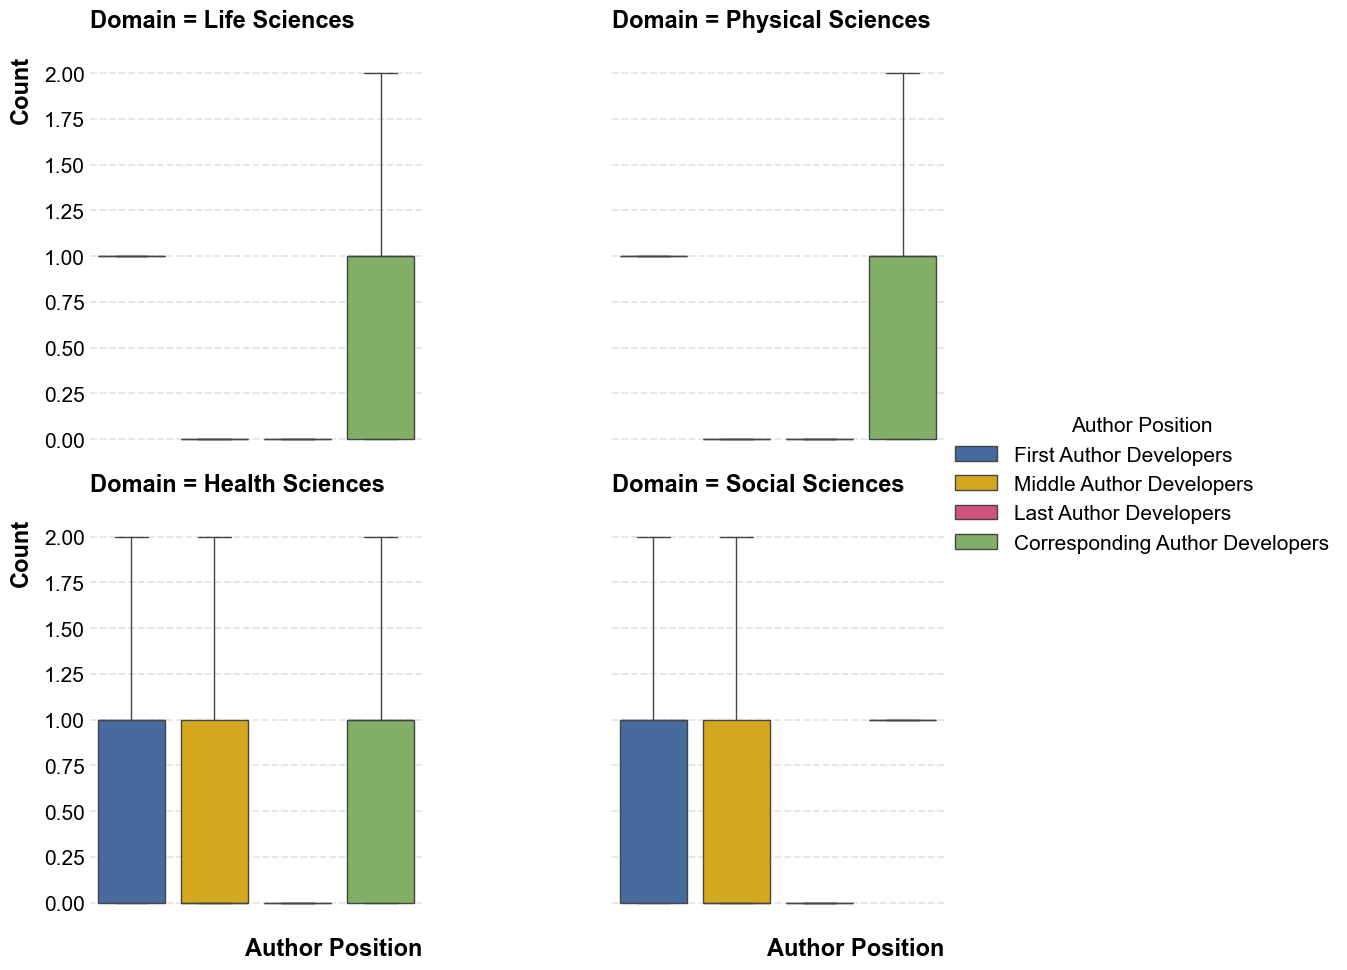

In [14]:
# Same thing split by domain
g = sns.catplot(
    data=per_paper_author_dev_contributors_long_df,
    x="Author Position",
    y="Count",
    hue="Author Position",
    col="Domain",
    col_order=per_paper_author_dev_contributors_df["Domain"]
    .value_counts()
    .index.tolist(),
    kind="box",
    # cut=0,
    showfliers=False,
    col_wrap=2,
    legend=True,
)

# Remove xlabels
for ax in g.axes.flat:
    ax.set_xticklabels([])

# Create dataframe of descriptive statistics
descriptive_stats = (
    per_paper_author_dev_contributors_df.groupby("Domain")
    .describe()
    .reset_index()
    .drop(columns=["document_id", "Year", "Document Citations"])
    .T
)
descriptive_stats

### Career Status of Developers

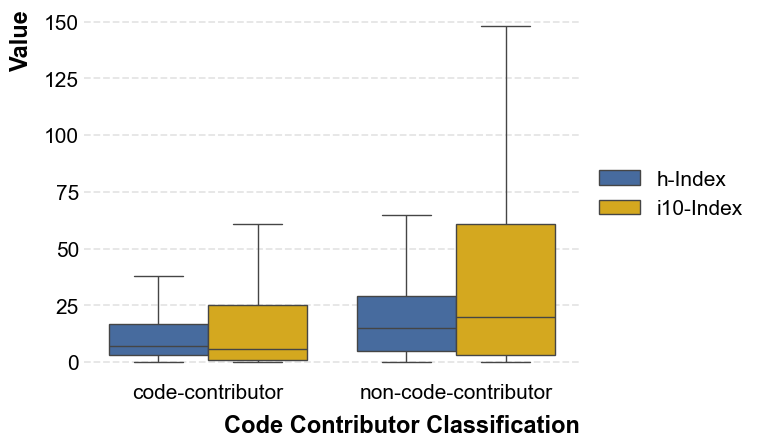

In [15]:
# Create a new dataframe that is the merge of:
# doc_contributors_df, matched_contributors_df, and doc_fields_df
# This will allow us to see author metrics
# attached to known developers and split by field

# Create a copy that is a subset of doc_contributors_df
code_doc_contribs_df = doc_contributors_df.copy()

# If the researcher_id is in matched_contributors_df then they are a code contributor
code_doc_contribs_df["code_contributor_cls"] = code_doc_contribs_df[
    "researcher_id"
].isin(matched_contributors_df["researcher_id"])

# Replace with string
code_doc_contribs_df["code_contributor_cls"] = code_doc_contribs_df[
    "code_contributor_cls"
].replace(
    {
        True: "code-contributor",
        False: "non-code-contributor",
    }
)

# Merge code_doc_contribs_df and doc_fields_df
code_doc_contribs_df = pd.merge(
    code_doc_contribs_df,
    doc_fields_df,
    how="inner",
    left_on="document_id",
    right_on="document_id",
)

# Select columns and the fields we want to use
matched_doc_contribs_df = (
    code_doc_contribs_df.groupby(
        "researcher_id",
    )
    .agg(
        {
            "document_researcher_position": "first",
            "code_contributor_cls": "first",
            # "researcher_works_count": "first",
            # "researcher_cited_by_count": "first",
            "researcher_h_index": "first",
            "researcher_i10_index": "first",
            # "researcher_two_year_mean_citedness": "first",
            "topic_field_name": lambda x: x.mode()[0],
        }
    )
    .reset_index()
)

# Rename columns
matched_doc_contribs_df = matched_doc_contribs_df.rename(
    columns={
        "code_contributor_cls": "Code Contributor Classification",
        # "researcher_works_count": "Articles",
        # "researcher_cited_by_count": "Total Citations",
        "researcher_h_index": "h-Index",
        "researcher_i10_index": "i10-Index",
        # "researcher_two_year_mean_citedness": "Two Year Mean Citedness",
        "topic_field_name": "Domain",
        "document_researcher_position": "Author Position",
    }
)

# Make long format
matched_doc_contribs_df_long = matched_doc_contribs_df.melt(
    id_vars=[
        "researcher_id",
        "Domain",
        "Code Contributor Classification",
        "Author Position",
    ],
    var_name="Metric",
    value_name="Value",
)

# Make boxplot
sns.boxplot(
    matched_doc_contribs_df_long,
    hue="Metric",
    y="Value",
    x="Code Contributor Classification",
    showfliers=False,
    legend=True,
)

# Move legend outside to middle right
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

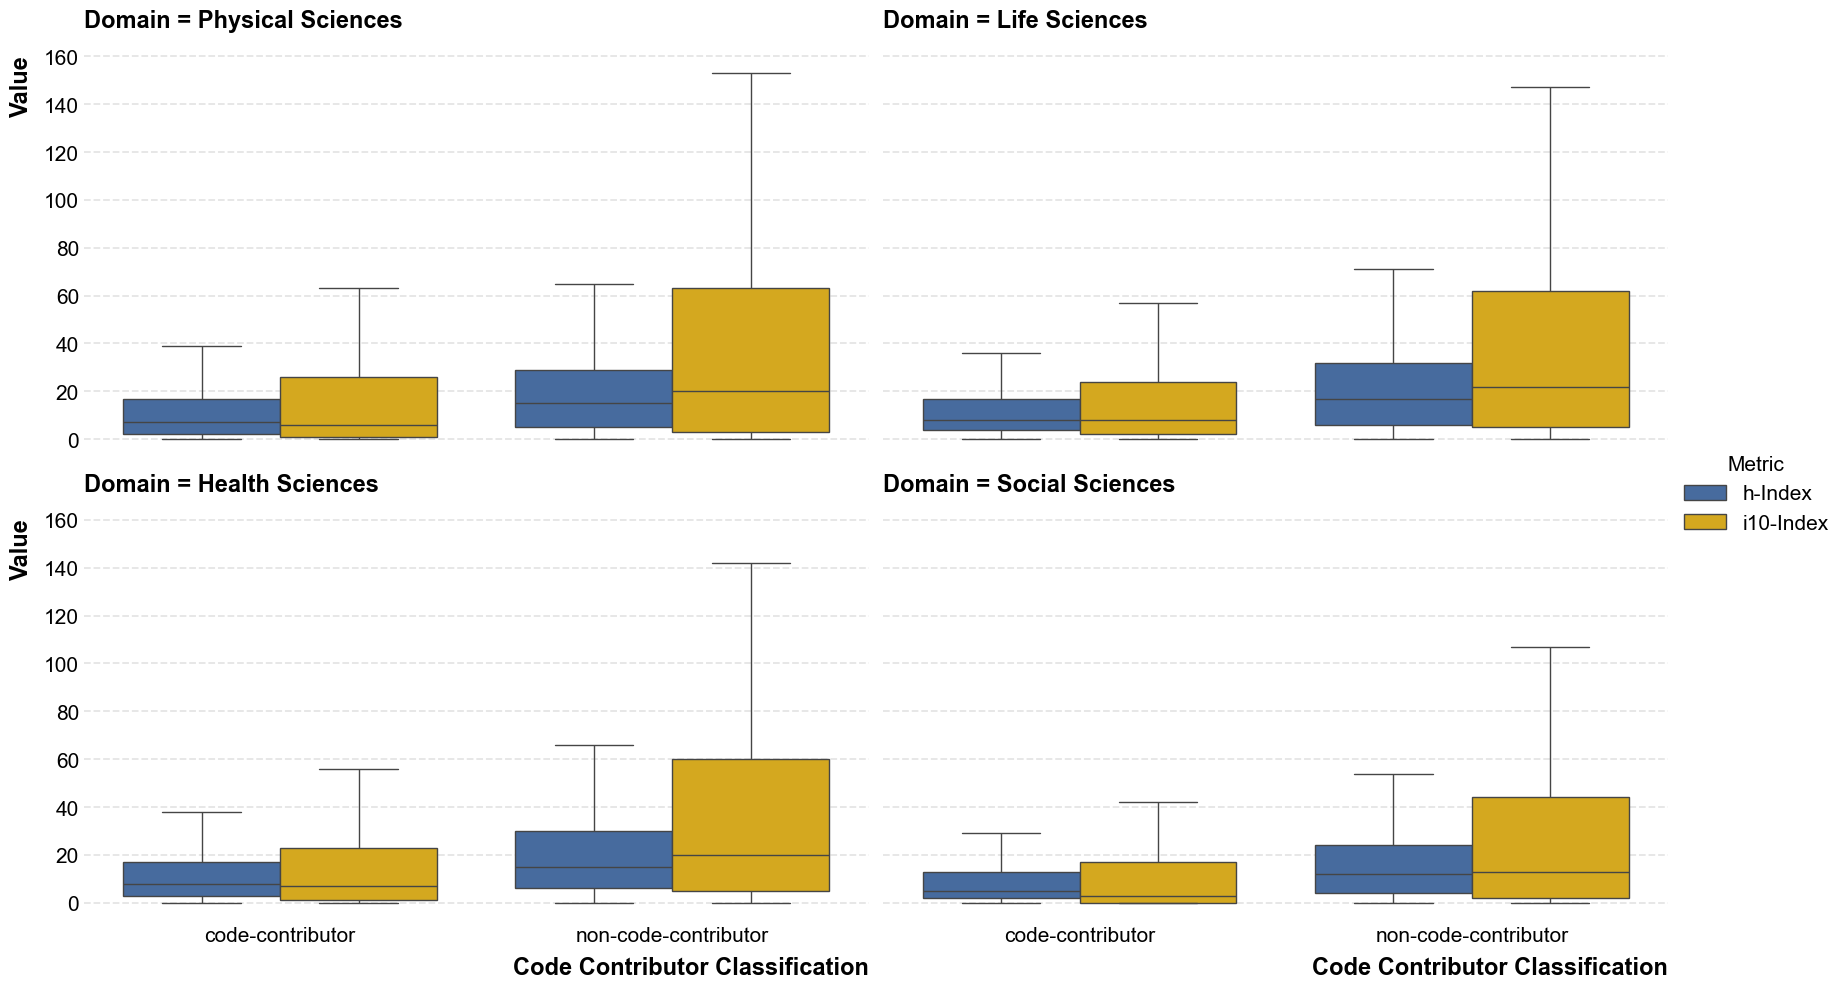

In [16]:
# Plot violinplots
sns.catplot(
    data=matched_doc_contribs_df_long,
    x="Code Contributor Classification",
    y="Value",
    hue="Metric",
    col="Domain",
    col_wrap=2,
    col_order=matched_doc_contribs_df["Domain"].value_counts().index.tolist(),
    kind="box",
    # cut=0,
    showfliers=False,
    legend=True,
    aspect=1.7,
)

In [17]:
# T-tests for each metric
for metric in matched_doc_contribs_df_long["Metric"].unique():
    code_contribs = matched_doc_contribs_df_long.loc[
        (matched_doc_contribs_df_long["Metric"] == metric)
        & (
            matched_doc_contribs_df_long["Code Contributor Classification"]
            == "code-contributor"
        )
    ]["Value"]
    non_code_contribs = matched_doc_contribs_df_long.loc[
        (matched_doc_contribs_df_long["Metric"] == metric)
        & (
            matched_doc_contribs_df_long["Code Contributor Classification"]
            == "non-code-contributor"
        )
    ]["Value"]

    ttest_result = ttest_ind(code_contribs, non_code_contribs)
    ci = ttest_result.confidence_interval()
    print(
        f"Metric: {metric}, "
        f"t-statistic: {ttest_result.statistic}, "
        f"p-value: {ttest_result.pvalue}, "
        f"ci-low: {ci.low} ci-high: {ci.high}"
    )

Metric: h-Index, t-statistic: -48.47334021458197, p-value: 0.0, ci-low: -7.575277058348423 ci-high: -6.9864814526418435
Metric: i10-Index, t-statistic: -3.2544918904935844, p-value: 0.0011363553087131118, ci-low: -8.874352281391614 ci-high: -2.2030711165322665


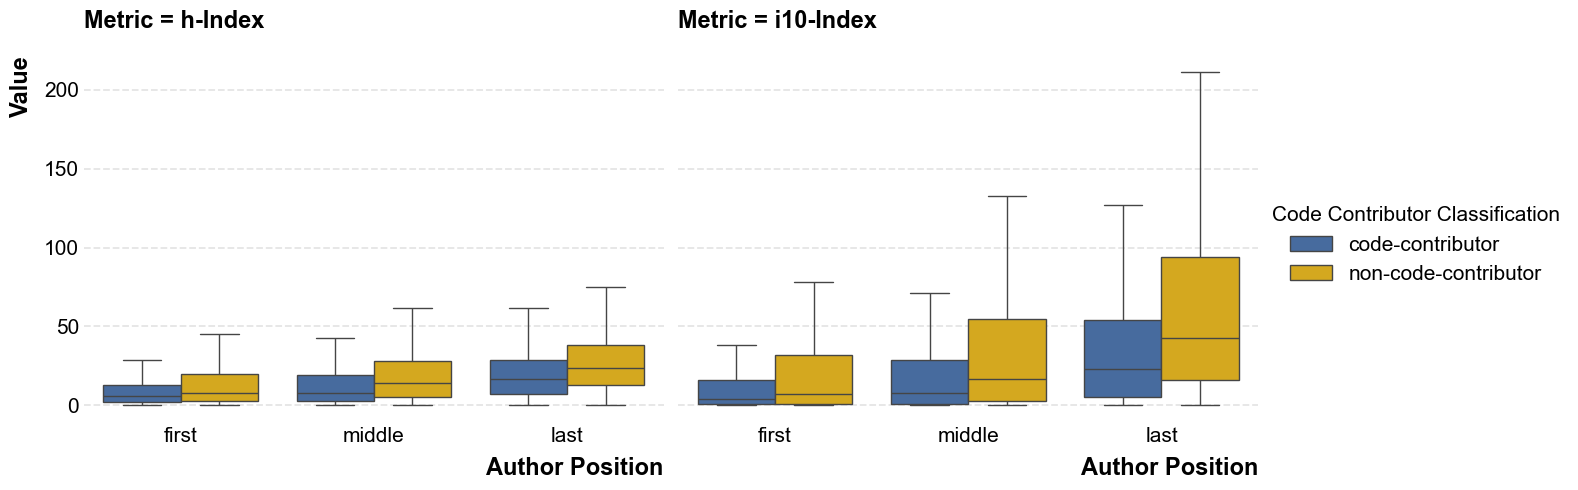

In [18]:
# Plot violinplots
sns.catplot(
    data=matched_doc_contribs_df_long,
    x="Author Position",
    y="Value",
    hue="Code Contributor Classification",
    col="Metric",
    # col_wrap=2,
    kind="box",
    # cut=0,
    showfliers=False,
    legend=True,
    aspect=1.3,
)

In [19]:
# T-tests for each metric
for position in matched_doc_contribs_df_long["Author Position"].unique():
    position_subset = matched_doc_contribs_df_long.loc[
        matched_doc_contribs_df_long["Author Position"] == position
    ]
    for metric in matched_doc_contribs_df_long["Metric"].unique():
        code_contribs = position_subset.loc[
            (position_subset["Metric"] == metric)
            & (position_subset["Code Contributor Classification"] == "code-contributor")
        ]["Value"]
        non_code_contribs = position_subset.loc[
            (position_subset["Metric"] == metric)
            & (
                position_subset["Code Contributor Classification"]
                == "non-code-contributor"
            )
        ]["Value"]

        ttest_result = ttest_ind(code_contribs, non_code_contribs)
        ci = ttest_result.confidence_interval()
        print(
            f"Position: {position} -- "
            f"Metric: {metric}, "
            f"t-statistic: {ttest_result.statistic}, "
            f"p-value: {ttest_result.pvalue}, "
            f"ci-low: {ci.low} ci-high: {ci.high}"
        )

Position: first -- Metric: h-Index, t-statistic: -14.909450364035763, p-value: 5.0288519381768895e-50, ci-low: -4.016129092242779 ci-high: -3.082859942006979
Position: first -- Metric: i10-Index, t-statistic: -3.026620325754303, p-value: 0.00247590966352462, ci-low: -14.710538209741202 ci-high: -3.1462736767037294
Position: middle -- Metric: h-Index, t-statistic: -18.241744037304663, p-value: 3.926826882567577e-74, ci-low: -4.84209000154148 ci-high: -3.902515477983943
Position: middle -- Metric: i10-Index, t-statistic: 6.773565871928232, p-value: 1.2686912839237174e-11, ci-low: 12.936036942943947 ci-high: 23.47073812366693
Position: last -- Metric: h-Index, t-statistic: -13.5655377174244, p-value: 1.1128334299703627e-41, ci-low: -7.222877199895363 ci-high: -5.39909694386097
Position: last -- Metric: i10-Index, t-statistic: 2.149183241042806, p-value: 0.03163541743008687, ci-low: 1.0337014343336595 ci-high: 22.467338153763713
